In [13]:
import torch
import torchvision
from torch import nn
import time
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from einops import rearrange
from torchvision import datasets, transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

import argparse
import sys
sys.argv = ['run.py']

import h5py
import copy

import numpy as np
import matplotlib.pylab as plt

In [14]:
# import D_vae
import Transformer

In [15]:
parser = argparse.ArgumentParser(description='Pre_train MNIST Example')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=20, metavar='N',
#                     help='how many batches to wait before logging training status')
parser.add_argument('--imgage-size', type=int, default=20,help='input image size')

parser.add_argument('--imgage-patch', type=int, default=4,help='segmentation image patch')

parser.add_argument('--channels', type=int, default=2, help='_')

parser.add_argument('--num-class', type=int, default=2,help='num class')

parser.add_argument('--mlp-dim', type=int, default=128, help='_')

parser.add_argument('--num_token',type=int, default=96, help='_')

parser.add_argument('--dropout-rate', type=int, default=0.3, help='_')


args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

In [16]:
#载入数据
data=[]
M_raw=[]

with h5py.File('four_phases_data/124_MT_20size_1T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41):   
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw=np.array(M_raw)
print(data.shape)

sample_num = data.shape[1]

data_num = data.shape[0]

data=data.reshape(-1, args.channels, args.imgage_size,args.imgage_size)

T = np.linspace(1,40,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<Tc else Phase_label.append(1)  for i in range(len(T)) for j in range(sample_num)]

Phase_label=np.array(Phase_label)

#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]

print(data_set.shape)
print(Phase_label.shape)
print(len(data_all))



#载入数据
data=[]
M_raw_test=[]

with h5py.File('four_phases_data/124_MT_20size_2T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41):   
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw_test.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw_test=np.array(M_raw_test)
print(data.shape)

sample_num = data.shape[1]

data_num = data.shape[0]

data=data.reshape(-1, args.channels, args.imgage_size, args.imgage_size)

T = np.linspace(1,40,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<Tc else Phase_label.append(1)  for i in range(len(T)) for j in range(sample_num)]

Phase_label=np.array(Phase_label)

#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all_test=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]

print(data_set.shape)
print(Phase_label.shape)
print(len(data_all_test))


(40, 500, 2, 20, 20)
torch.Size([20000, 2, 20, 20])
torch.Size([20000])
20000
(40, 500, 2, 20, 20)
torch.Size([20000, 2, 20, 20])
torch.Size([20000])
20000


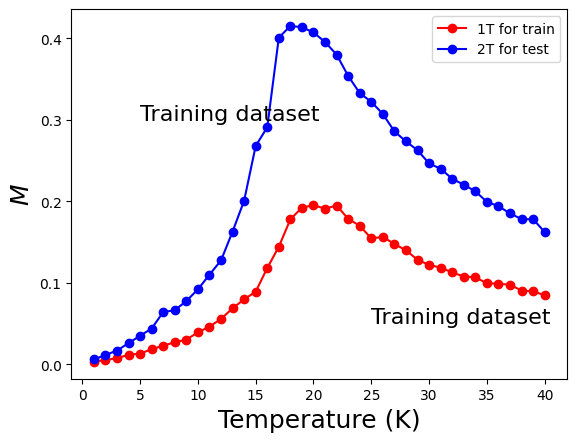

In [17]:
plt.plot(T,M_raw,'ro-',label='1T for train')

plt.plot(T,M_raw_test,'bo-',label='2T for test')

plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)


plt.text(25,0.05,'Training dataset',fontsize=16)
plt.text(5,0.30,'Training dataset',fontsize=16)


plt.legend()
plt.show()

In [7]:
train_loader = DataLoader(data_all, batch_size = args.batch_size, shuffle=True)
test_loader = DataLoader(data_all_test, batch_size = args.batch_size, shuffle=True )

# shuffled_indices = np.random.permutation(len(data_all))
# train_idx = shuffled_indices[:int(0.8*len(data_all))]
# val_idx = shuffled_indices[int(0.8*len(data_all)):]

# train_loader = DataLoader(data_all, batch_size = args.batch_size, drop_last=False, sampler=SubsetRandomSampler(train_idx))
# test_loader = DataLoader(data_all, batch_size = args.batch_size, drop_last=False, sampler=SubsetRandomSampler(val_idx) )

In [9]:
Model_vit = Transformer.ViT(image_size=args.imgage_size, patch_size=args.imgage_patch, num_classes=args.num_class, channels=args.channels,
            dim=24, depth=3, heads=8, mlp_dim=args.mlp_dim, dropout_rate=0.4,token_class=128)#args.dropout_rate
Model_vit.to(device)
optimizer = torch.optim.Adam(Model_vit.parameters(), lr=5e-4)#,eps=1e-4
train_loss_history, test_loss_history, Accuracy_rate = [], [], []

In [10]:
%%time
for epoch in range(1, args.epochs + 1):#10
    # print('Epoch:', epoch)
    Transformer.fine_tune_train(Model_vit, optimizer, train_loader, train_loss_history,epoch)
    Transformer.fine_tune_evaluate(Model_vit, test_loader, test_loss_history, Accuracy_rate, epoch)

Epoch 1: Average train loss : 0.22922
Epoch 1: Average test loss: 0.17632  Accuracy:18905/20000 (94.52%)

Epoch 2: Average train loss : 0.10782
Epoch 2: Average test loss: 0.17608  Accuracy:18850/20000 (94.25%)

Epoch 3: Average train loss : 0.10164
Epoch 3: Average test loss: 0.21740  Accuracy:18642/20000 (93.21%)

Epoch 4: Average train loss : 0.09782
Epoch 4: Average test loss: 0.22650  Accuracy:18643/20000 (93.21%)

Epoch 5: Average train loss : 0.09529
Epoch 5: Average test loss: 0.22353  Accuracy:18628/20000 (93.14%)

Epoch 10: Average train loss : 0.07343
Epoch 10: Average test loss: 0.25777  Accuracy:18640/20000 (93.20%)

Epoch 20: Average train loss : 0.04346
Epoch 20: Average test loss: 0.25054  Accuracy:18857/20000 (94.28%)

Epoch 30: Average train loss : 0.03508
Epoch 30: Average test loss: 0.30422  Accuracy:18841/20000 (94.20%)

Epoch 40: Average train loss : 0.03084
Epoch 40: Average test loss: 0.23780  Accuracy:18958/20000 (94.79%)

Epoch 50: Average train loss : 0.02583

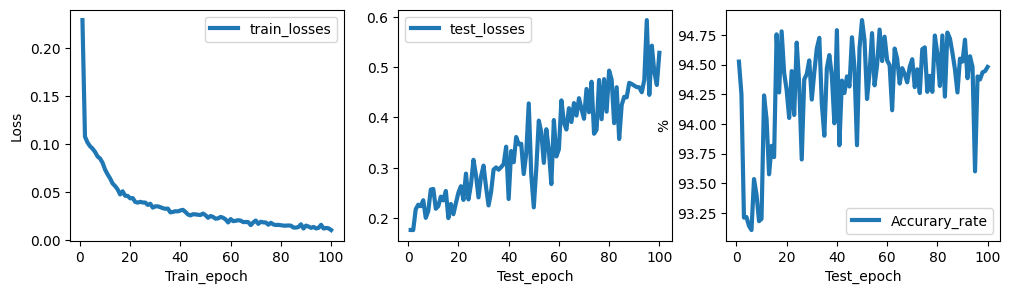

In [11]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(131)
ax1.plot(np.arange(1,len(train_loss_history)+1),train_loss_history, linewidth=3, linestyle='-', label='train_losses')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(1,len(test_loss_history)+1),test_loss_history, linewidth=3, linestyle='-', label='test_losses')
ax2.set_xlabel('Test_epoch')
ax2.legend()

ax3=plt.subplot(133)
ax3.plot(np.arange(1,len(Accuracy_rate)+1),(Accuracy_rate), linewidth=3, linestyle='-', label='Accurary_rate')
ax3.set_xlabel('Test_epoch')
ax3.set_ylabel('%')
ax3.legend()

plt.show()

In [12]:
for i in range(0,20000,500):
    A_test=data_all_test[i:i+500]
    Model_vit.eval()
    all=0
    with torch.no_grad():
        for img ,label in A_test:
            img=img.cuda()
            img=img.view(-1,2,20,20)
            A=nn.Softmax(dim=-1)(Model_vit(img,mask=False,classification=True)).argmax(dim=-1)
            all+=A
            # print(A)
        print('{} K The number of PM by model is {}'.format((int(i/500+1)), all.cpu().numpy()))

1 K The number of PM by model is [0]
2 K The number of PM by model is [0]
3 K The number of PM by model is [0]
4 K The number of PM by model is [0]
5 K The number of PM by model is [0]
6 K The number of PM by model is [0]
7 K The number of PM by model is [0]
8 K The number of PM by model is [0]
9 K The number of PM by model is [0]
10 K The number of PM by model is [0]
11 K The number of PM by model is [0]
12 K The number of PM by model is [0]
13 K The number of PM by model is [0]
14 K The number of PM by model is [0]
15 K The number of PM by model is [0]
16 K The number of PM by model is [3]
17 K The number of PM by model is [238]
18 K The number of PM by model is [394]
19 K The number of PM by model is [409]
20 K The number of PM by model is [471]
21 K The number of PM by model is [491]
22 K The number of PM by model is [491]
23 K The number of PM by model is [497]
24 K The number of PM by model is [494]
25 K The number of PM by model is [498]
26 K The number of PM by model is [499]
2